In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [16]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Covid_Dataset',labels='inferred',label_mode='int',
                                                              batch_size=32,image_size=(256,256),shuffle=True,seed=42)

Found 4152 files belonging to 2 classes.


In [17]:
class_names = train_data.class_names
class_names

['covid_image', 'normal_image']

In [19]:
len(train_data)

130

In [22]:
for image_batch, labels_batch in train_data.take(2):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0]
(32, 256, 256, 3)
[0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0]


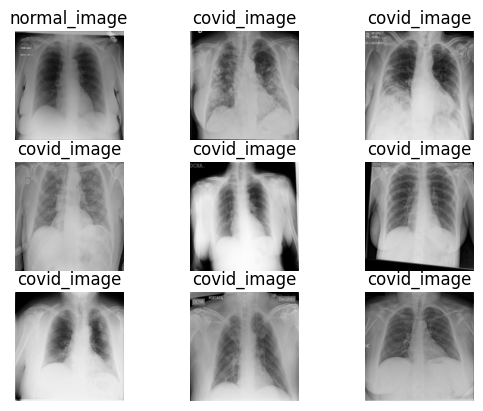

In [47]:
for image_batch,label_batch in train_data.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [48]:
ds_size = len(train_data)
train_pct = 0.8
train_ds = train_data.take(int(train_pct*ds_size))
test_ds = train_data.skip(int(train_pct*ds_size))
val_pct = 0.6
test_ds_size = len(test_ds)
val_ds = test_ds.take(int(val_pct*test_ds_size))
test_ds = train_data.skip(int(val_pct*test_ds_size))

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [50]:
resizeandrescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),

])

In [51]:
dataAugument = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [56]:
input_shape = (256,256,3)

In [76]:
from keras.applications import ResNet50,VGG19
from keras.layers import Input, Dense, GlobalAveragePooling2D

In [64]:
dnn_model = Sequential()
imported_model=ResNet50(include_top=False,
input_shape=input_shape,
pooling='avg',classes=2,
weights='imagenet')
for layer in imported_model.layers:
  layer.trainable=False
dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(2, activation='softmax'))
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [66]:
from keras.optimizers import Adam
dnn_model.compile(optimizer=Adam(0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [67]:
history = dnn_model.fit(
train_ds,
validation_data=val_ds,
epochs=10
)

Epoch 1/10
104/104 [==============================] - 19s 151ms/step - loss: 0.3843 - accuracy: 0.8489 - val_loss: 0.1620 - val_accuracy: 0.9354
Epoch 2/10
104/104 [==============================] - 16s 149ms/step - loss: 0.1852 - accuracy: 0.9270 - val_loss: 0.1742 - val_accuracy: 0.9375
Epoch 3/10
104/104 [==============================] - 14s 138ms/step - loss: 0.1574 - accuracy: 0.9384 - val_loss: 0.1231 - val_accuracy: 0.9563
Epoch 4/10
104/104 [==============================] - 14s 138ms/step - loss: 0.1163 - accuracy: 0.9540 - val_loss: 0.1296 - val_accuracy: 0.9521
Epoch 5/10
104/104 [==============================] - 15s 140ms/step - loss: 0.1049 - accuracy: 0.9543 - val_loss: 0.0993 - val_accuracy: 0.9604
Epoch 6/10
104/104 [==============================] - 14s 139ms/step - loss: 0.0745 - accuracy: 0.9721 - val_loss: 0.1189 - val_accuracy: 0.9646
Epoch 7/10
104/104 [==============================] - 14s 140ms/step - loss: 0.0822 - accuracy: 0.9642 - val_loss: 0.1374 - val_ac

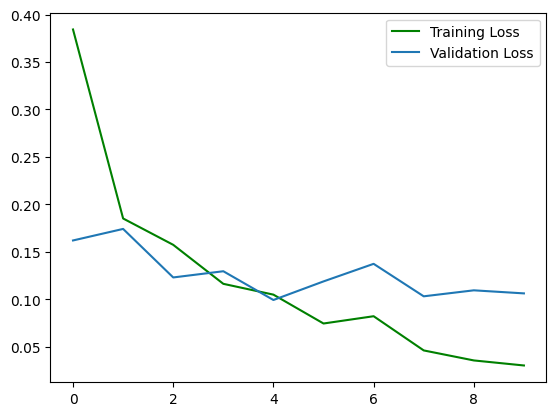

In [72]:
plt.plot(history.history["loss"], color='green')
plt.plot(history.history["val_loss"])
plt.legend(["Training Loss","Validation Loss"])


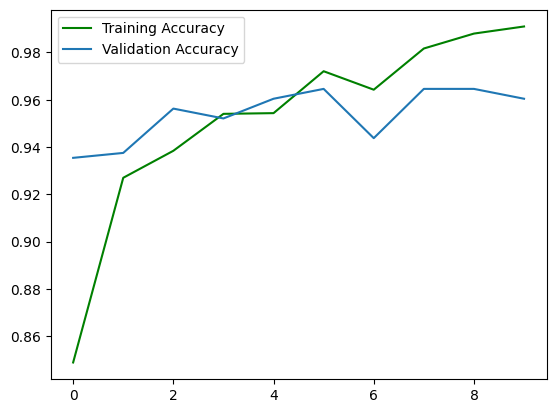

In [73]:
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"])
plt.legend(["Training Accuracy","Validation Accuracy"])

In [75]:
dnn_model.evaluate(test_ds)

115/115 [==============================] - 15s 131ms/step - loss: 0.0395 - accuracy: 0.9883


[0.039483871310949326, 0.9882897734642029]

In [78]:
vgg_model = Sequential()
imported_model=VGG19(include_top=False,
input_shape=input_shape,
pooling='avg',classes=2,
weights='imagenet')
for layer in imported_model.layers:
  layer.trainable=False
vgg_model.add(imported_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(2, activation='softmax'))
vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 20288066 (77.39 MB)
Trainable params: 263682 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [79]:
vgg_model.compile(optimizer=Adam(0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [80]:
history = vgg_model.fit(
train_ds,
validation_data=val_ds,
epochs=10
)

Epoch 1/10
104/104 [==============================] - 33s 261ms/step - loss: 0.6389 - accuracy: 0.8308 - val_loss: 0.2088 - val_accuracy: 0.9104
Epoch 2/10
104/104 [==============================] - 23s 226ms/step - loss: 0.1663 - accuracy: 0.9315 - val_loss: 0.3698 - val_accuracy: 0.8646
Epoch 3/10
104/104 [==============================] - 23s 225ms/step - loss: 0.1489 - accuracy: 0.9441 - val_loss: 0.1633 - val_accuracy: 0.9333
Epoch 4/10
104/104 [==============================] - 24s 229ms/step - loss: 0.0992 - accuracy: 0.9627 - val_loss: 0.1599 - val_accuracy: 0.9438
Epoch 5/10
104/104 [==============================] - 26s 250ms/step - loss: 0.0907 - accuracy: 0.9624 - val_loss: 0.1928 - val_accuracy: 0.9271
Epoch 6/10
104/104 [==============================] - 24s 226ms/step - loss: 0.0864 - accuracy: 0.9657 - val_loss: 0.1344 - val_accuracy: 0.9521
Epoch 7/10
104/104 [==============================] - 24s 229ms/step - loss: 0.0621 - accuracy: 0.9757 - val_loss: 0.1522 - val_ac

In [81]:
vgg_model.evaluate(test_ds)

115/115 [==============================] - 26s 230ms/step - loss: 0.1182 - accuracy: 0.9578


[0.11819012463092804, 0.9577886462211609]